### two encoding blocks, two deconding blocks, deep supervision

In [35]:
from keras.layers import Conv3D, BatchNormalization, Add, Dropout, Input, MaxPooling3D, Flatten, Dense, Conv3DTranspose
from keras.optimizers import Adam
from keras.models import load_model, Model
from keras.utils import to_categorical, plot_model
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
from livelossplot.keras import PlotLossesCallback

import numpy as np
import os

from cv2 import imread, resize
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
images = [np.load(os.path.join('4d_images',file)) for file in os.listdir('4d_images')]
labels = [np.load(os.path.join('4d_labels',file)) for file in os.listdir('4d_labels')]

In [37]:
images[0].shape

(4, 112, 112, 3)

In [38]:
#y = to_categorical(labels)
X = images
y = labels

In [39]:
time = 4
height = 112
width = 112

In [40]:
img = images[0][0,:,:,:]

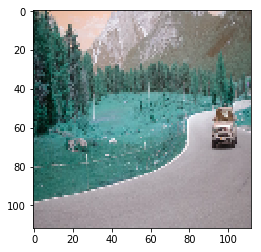

In [41]:
plt.imshow(img)

In [42]:


X = np.array(X)
X = X / 255.

y = np.array(y)

In [43]:

(X.shape, y.shape)

((20, 4, 112, 112, 3), (20, 4, 112, 112, 3))

In [44]:
#X = images

In [45]:
def RCL3D_block(filedepth, inpt):
    '''
    recurrent convolution block
    ARGUMENTS: filedepth, int, represents the no of conv filters, input layer is a convolutional neural network layer
    RETURNS stack8, neural net layer
    '''
    conv1 = Conv3D(filters=filedepth, kernel_size=3, strides=(1, 1,1), padding='same',activation='relu')(inpt)
    stack2 = BatchNormalization()(conv1)

    RCL = Conv3D(filters=filedepth, kernel_size=3, strides=(1, 1,1), padding='same', activation='relu')

    conv2 = RCL(stack2)
    stack3 = Add()([conv1, conv2])
    stack4 = BatchNormalization()(stack3)

    conv3 = Conv3D(filters=filedepth, kernel_size=2, strides=(1, 1,1), padding='same',activation='relu')(stack4)
    stack5 =  Add()([conv1, conv3])
    stack6 = BatchNormalization()(stack5)

    conv4 = Conv3D(filters=filedepth, kernel_size=[3, 3,3], strides=(1, 1,1), padding='same',activation='softmax')(stack6)
    stack7 =  Add()([conv1, conv4])
    stack8 = BatchNormalization()(stack7)

    return stack8

In [46]:
def model(t,h,w,c):
    """
    Arguments:

    Returns:
    model -- Keras model instance
    """
    
    #________________________INPUT_________________________________________
    input_brick = Input(shape=(t,h,w,c)) #will be (4,112,112,3)
    
    #________________________ENCODING NETWORK 1_________________________________________
    conv_1e = Conv3D(filters=64,kernel_size=[3,3,3],strides=(1,1,1),padding='same',activation='relu')(input_brick)
    # since padding = same, size is still (4,112,112,3)
    maxpool_1e = MaxPooling3D((2,2,2), strides=(2,2,2), padding='valid')(conv_1e)
    # since padding = valid, size is  (2,56,56,3)
    
    #_______________________DECODING NETWORK 1____________________________________________
    deconv_1d = Conv3DTranspose(filters=1,kernel_size=[3,3,3],strides=(2,2,2),padding='same',
                               activation='relu')(maxpool_1e) #deconv5b-UpSmp in caffe
    # since padding = same, size is (4,112,112,3)
    rconv_1d = RCL3D_block(65, deconv_1d)
    #_______________________Out___________________________________________________________
    out_1 = Conv3D(filters=3,kernel_size=[3,3,3],strides=(1,1,1),padding='same',activation='relu')(rconv_1d)
    
    #________________________ENCODING NETWORK 2_________________________________________
    conv_2e = Conv3D(filters=128,kernel_size=[3,3,3],strides=(1,1,1),padding='same',activation='relu')(maxpool_1e)
    # since padding = same, size is still (2,56,56,3)
    maxpool_2e = MaxPooling3D((2,2,2), strides=(2,2,2), padding='valid')(conv_2e)
    # since padding = valid, size is  (1,28,28,3)
    
    #_______________________DECODING NETWORK 2____________________________________________
    deconv_2d = Conv3DTranspose(filters=1,kernel_size=[3,3,3],strides=(2,2,2),padding='same',
                               activation='relu')(maxpool_2e) #deconv5b-UpSmp in caffe
    # since padding = same, size is (2,56,56,3)
    rconv_2d = RCL3D_block(65, deconv_2d)
    deconv_3d = Conv3DTranspose(filters=1,kernel_size=[3,3,3],strides=(2,2,2),padding='same',
                               activation='relu')(rconv_2d) #deconv5b-UpSmp in caffe
    # since padding = same, size is (4,112,112,3)
    rconv_3d = RCL3D_block(128, deconv_3d)
    
    
    #_______________________Out_______________________filters = 3 for RGB ground thruth
    out_1 = Conv3D(filters=3,kernel_size=[3,3,3],strides=(1,1,1),padding='same',activation='relu')(rconv_1d)
    # since padding = same, size is still (4,112,112,3)
    out_2 = Conv3D(filters=3,kernel_size=[3,3,3],strides=(1,1,1),padding='same',activation='relu')(rconv_3d)
    # since padding = same, size is still (4,112,112,3)


    # Step 3: Create model instance 
    model = Model(inputs=[input_brick], outputs=[out_1,out_2])
    
    return model

In [47]:
model = model(time,height,width,3)

In [48]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 4, 112, 112,  0                                            
__________________________________________________________________________________________________
conv3d_35 (Conv3D)              (None, 4, 112, 112,  5248        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling3d_5 (MaxPooling3D)  (None, 2, 56, 56, 64 0           conv3d_35[0][0]                  
__________________________________________________________________________________________________
conv3d_41 (Conv3D)              (None, 2, 56, 56, 12 221312      max_pooling3d_5[0][0]            
__________________________________________________________________________________________________
max_poolin

In [49]:
#SVG(model_to_dot(model).create(prog='dot',format='svg'))
#plot_model(model, to_file='model.png')

In [50]:
adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['accuracy'])

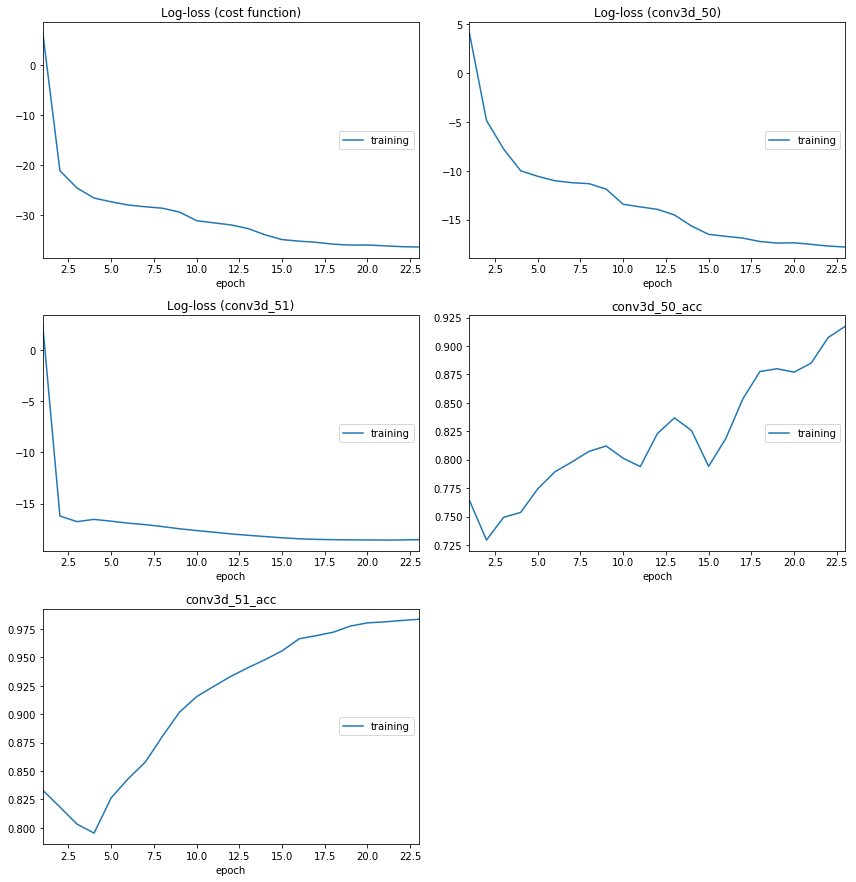

Log-loss (cost function):
training   (min:  -36.319, max:    6.406, cur:  -36.319)

Log-loss (conv3d_50):
training   (min:  -17.796, max:    4.074, cur:  -17.796)

Log-loss (conv3d_51):
training   (min:  -18.563, max:    2.332, cur:  -18.523)

conv3d_50_acc:
training   (min:    0.729, max:    0.917, cur:    0.917)

conv3d_51_acc:
training   (min:    0.795, max:    0.984, cur:    0.984)


In [51]:
model.fit(X,[y,y], batch_size=8, epochs=23, callbacks=[PlotLossesCallback()],verbose=0)